In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import io

In [2]:
data = sp.io.loadmat('data/2013_DFC_contest.mat')

In [35]:
rgb_bands = [54,32,18]
hsi_rgb = data['hyper'][:,:,rgb_bands]
hsi_rgb = hsi_rgb/hsi_rgb.max()

pmin,pmax = np.percentile(hsi_rgb,(1,95),axis=(0,1))
hsi_rgb_pimped = hsi_rgb.copy()
for i in range(pmin.size):
    hsi_rgb_pimped[:,:,i] = (hsi_rgb[:,:,i]-pmin[i])/(pmax[i]-pmin[i])
hsi_rgb_pimped[hsi_rgb_pimped<0] = 0
hsi_rgb_pimped[hsi_rgb_pimped>1] = 1

In [3]:
groundtruth = np.load('groundtruth/groundtruth.npy')
groundtruth_info = np.load('groundtruth/groundtruth_info.npy',allow_pickle=True)
groundtruth_rgb = plt.imread('groundtruth/groundtruth.png')

In [4]:
groundtruth_info

array([{'class_name': 'grass_healthy', 'class_label': 1, 'class_color': array([  0, 205,   0])},
       {'class_name': 'grass_stressed', 'class_label': 2, 'class_color': array([127, 255,   0])},
       {'class_name': 'grass_synthetic', 'class_label': 3, 'class_color': array([ 46, 205,  87])},
       {'class_name': 'tree', 'class_label': 4, 'class_color': array([  0, 139,   0])},
       {'class_name': 'soil', 'class_label': 5, 'class_color': array([160,  82,  45])},
       {'class_name': 'water', 'class_label': 6, 'class_color': array([  0, 255, 255])},
       {'class_name': 'residential', 'class_label': 7, 'class_color': array([255, 255, 255])},
       {'class_name': 'commercial', 'class_label': 8, 'class_color': array([216, 191, 216])},
       {'class_name': 'road', 'class_label': 9, 'class_color': array([255,   0,   0])},
       {'class_name': 'highway', 'class_label': 10, 'class_color': array([139,   0,   0])},
       {'class_name': 'railway', 'class_label': 11, 'class_color': array

In [79]:
lidar = data['lidar']
print("L'image LiDAR est composée de %d lignes et %d colonnes "%(lidar.shape)+"au format %s"%lidar.dtype)
hsi_raw = data['hyper']
print("L'image hyperspectrale est composée de %d lignes, %d colonnes et %d bandes "%(hsi_raw.shape)
      +"au format %s"%hsi_raw.dtype)

L'image LiDAR est composée de 349 lignes et 1905 colonnes au format float32
L'image hyperspectrale est composée de 349 lignes, 1905 colonnes et 144 bandes au format uint16


(349, 1905, 144)

In [170]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# normalize the data
scaler = MinMaxScaler()

r,c,N = hsi_raw.shape
hsi = hsi_raw.reshape(r*c,N)

#fusion lidar and hsi for the whole image
allData = np.concatenate((hsi, lidar.reshape(-1, 1)), axis=1)

# we take only pixels with a grountruth known
hsi_train = hsi_raw[groundtruth != 0]
lidar_train = lidar[groundtruth != 0]

#normalize training sets
lidar_train = scaler.fit_transform(lidar_train.reshape(-1, 1))
hsi_train = scaler.fit_transform(hsi_train)

# fusion lidar and hsi sets
x_train = np.concatenate((hsi_train, lidar_train.reshape(-1, 1)), axis=1)
y_train = groundtruth[groundtruth != 0]

#check shapes
allData.shape, hsi_train.shape, lidar_train.shape, x_train.shape, y_train.shape

((664845, 145), (2832, 144), (2832, 1), (2832, 145), (2832,))

In [177]:
#chose the training set and image type to predict
x_train = hsi_train
toPredict = hsi

In [173]:
#### from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split


# Split the dataset into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train)

# Print the shape of the resulting training and validation sets
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)

x_train shape: (1812, 144)
y_train shape: (1812,)
x_val shape: (453, 144)
y_val shape: (453,)


In [174]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier


#classifier = LinearSVC(random_state=1, max_iter=10000)
classifier = RandomForestClassifier(max_depth=7, random_state=1)
classifier = classifier.fit(x_train, y_train)

# evaluate the model on the validation set y_val
score = classifier.score(x_val, y_val)
print("Validation set score:", score)

Validation set score: 0.739514348785872


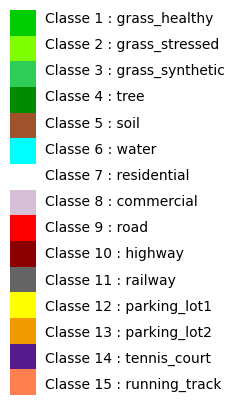

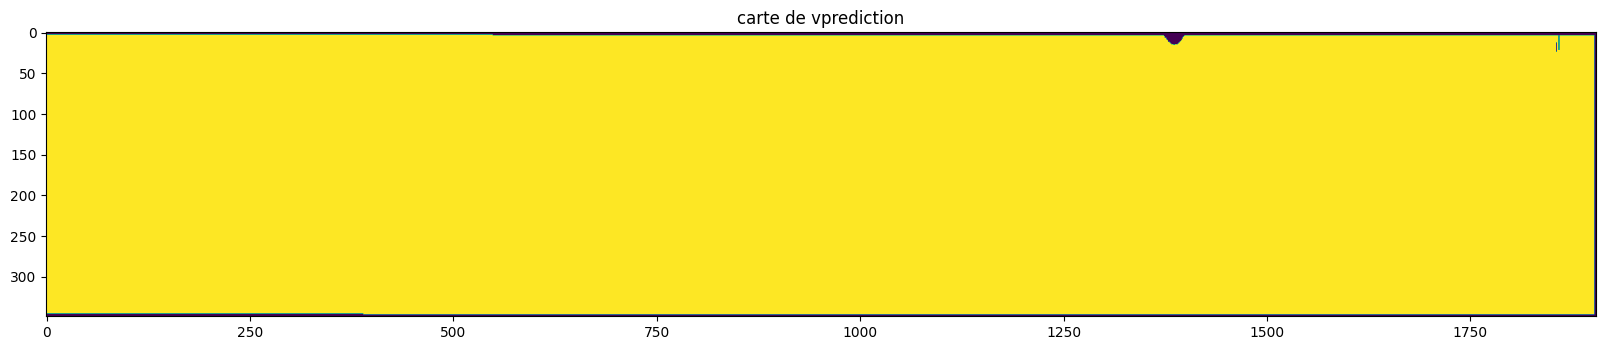

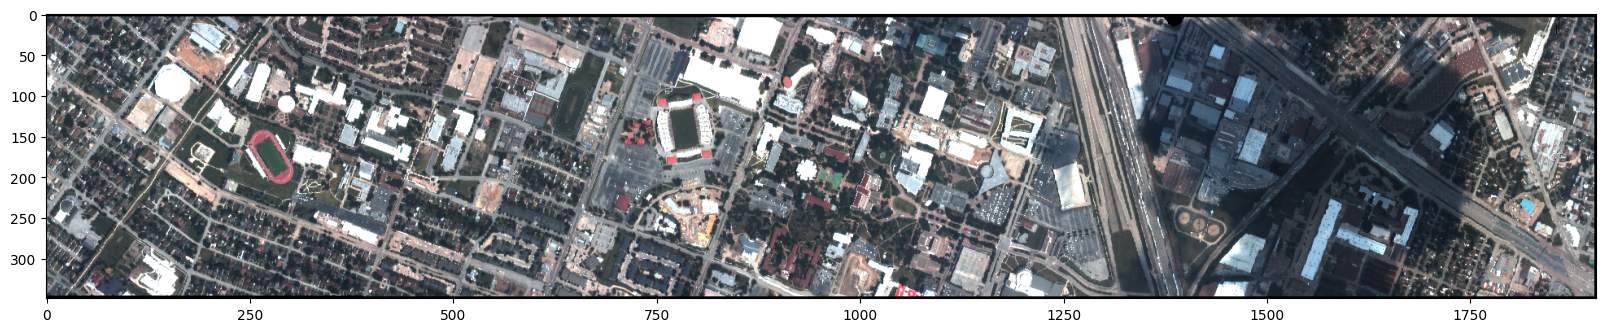

In [178]:
# predict for the whole image
prediction = classifier.predict(toPredict)

cls_rgb = []
for ii in groundtruth_info:
    cls_rgb.append(ii['class_color'])
cls_rgb = np.array(cls_rgb).reshape(15,-1,3)
plt.figure(figsize=(5,5))
plt.imshow(cls_rgb)
plt.axis('off')
for cls in range(15):
        plt.text(0.85,1.02*cls,'Classe %d : %s'%(cls+1,groundtruth_info[cls]['class_name']))
plt.show()

plt.figure(figsize=(20,5))
plt.title('carte de vprediction')
plt.imshow(prediction.reshape((349,1905)))
plt.show()

plt.figure(figsize=(20,5))
plt.imshow(hsi_rgb_pimped)
plt.show()